In [1122]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy.stats import norm, chi2, chisquare
pd.set_option('display.max_columns', None)

In [1123]:
sample = [
    162,
    143,
    170,
    162,
    163,
    151,
    164,
    161,
    163,
    165,
    159,
    163,
    170,
    166,
    168,
    155,
    164,
    165,
    174,
    159,
    165,
    170,
    158,
    159,
    160,
    158,
    160,
    162,
    166,
    163,
    164,
    165,
    165,
    158,
    158,
    160,
    163,
    164,
    170,
    169,
    170,
    172,
    170,
    165,
    158,
    164,
    171,
    176,
    170,
    158,
    165,
    160,
    164,
    167,
    170,
    161,
    160,
    165,
    165,
    158,
    170,
    168,
    168,
    160,
    164,
    158,
    160,
    162,
    156,
    170,
    163,
    160,
    163,
    168,
    162,
    165,
    163,
    163,
    165,
    158,
    168,
    164,
    171,
    166,
    160,
    160,
    162,
    164,
    155,
    169,
    165,
    165,
    165,
    165,
    166,
    164,
    164,
    150,
    165,
    170,
    175,
    160,
    165,
    166,
    162,
    168,
    164,
    164,
    170,
    164,
    167,
    160,
    168,
    158,
    170,
    165,
]

In [1124]:
data = Counter(sorted(sample))

In [1125]:
df = pd.DataFrame(data, index=["n_i"]).rename_axis("x_(i)", axis="columns")
df

x_(i),143,150,151,155,156,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,174,175,176
n_i,1,1,1,2,1,10,3,12,2,7,9,14,18,5,2,7,2,13,2,1,1,1,1


In [1126]:
n = df.loc["n_i"].sum()
X = (df.keys().to_numpy()*df.loc["n_i"].to_numpy()).sum()/n

S2 = ((df.loc["n_i"].to_numpy()*(df.keys().to_numpy()-X)**2)).sum()/(n)
print(f"X: {X}")
print(f"S^2: {S2}")


X: 163.81896551724137
S^2: 25.199985136741976


In [1127]:
m = (np.log2(n) + 1).astype(np.int64)
print(f"m: {m}")
x_min = df.keys().to_numpy().min()
x_max = df.keys().to_numpy().max()
step = (x_max - x_min) / m
inters = [(x_min + step * i, x_min + step * (i + 1)) for i in range(m)]
union_data = defaultdict(int)
for key in df.keys():
    for i, inter in enumerate(inters):
        if inter[0] <= key < inter[1] or i == m - 1 and inter[0] <= key <= inter[1]:
            union_data[
                f"[{inter[0]:.2f}; {inter[1]:.2f}{"]" if i == m-1 else ")"}"
            ] += df[key].loc["n_i"]
            break
    else:
        print(key)
union_df = pd.DataFrame(data=union_data, index=["n_k"]).rename_axis(
    "J_k", axis="columns"
)
union_df

m: 7


J_k,[143.00; 147.71),[147.71; 152.43),[152.43; 157.14),[157.14; 161.86),[161.86; 166.57),[166.57; 171.29),[171.29; 176.00]
n_k,1,2,3,27,53,26,4


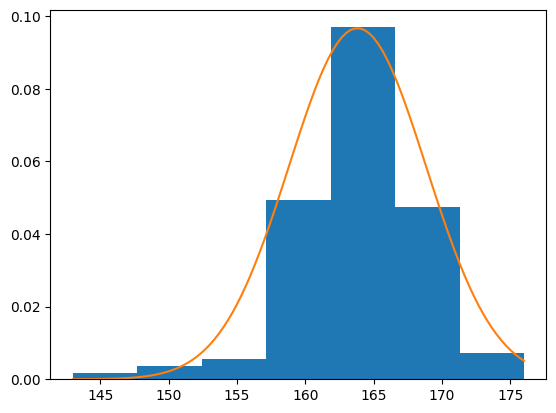

In [1128]:

y, _, _ = plt.hist(df.keys(), bins=[x_min + step * i for i in range(m+1)], weights=df.loc["n_i"]/(n*step))

x = np.linspace(x_min, x_max, 100)
plt.plot(x, norm.pdf((x-X)/np.sqrt(S2))/0.4*(y.max()))
plt.savefig("hist.pdf")

In [1129]:
normal = lambda x: norm.cdf((x - X) / np.sqrt(S2))
chi_df = pd.DataFrame(
    {"n_k": union_df.loc["n_k"]}, index=union_df.keys().to_numpy()
).rename(
    index={"[143.00; 147.71)": "(-inf; 147.71)", "[171.29; 176.00]": "[171.29; inf)"}
)
max_inter = [x_min + step * i for i in range(1, m)]
chi_df = pd.concat(
    [
        chi_df,
        pd.DataFrame(
            {
                "p_k": [normal(inters[0][1])]
                + [normal(x2) - normal(x1) for x1, x2 in inters[1:-1]]
                + [1 - normal(inters[-1][0])]
            },
            index=chi_df.index,
        ),
    ],
    axis="columns",
)
chi_df = pd.concat(
    [chi_df, pd.DataFrame({"np_k": n * chi_df.p_k}, index=chi_df.index)], axis="columns"
)
chi_df


,n_k,p_k,np_k
(-inf; 147.71),1,0.000668,0.077489
[147.71; 152.43),2,0.010966,1.271998
[152.43; 157.14),3,0.080140,9.296235
[157.14; 161.86),27,0.256197,29.718897
[161.86; 166.57),53,0.360288,41.793353
[166.57; 171.29),26,0.223289,25.901484
[171.29; inf),4,0.068453,7.940544


In [1130]:
union_chi_df = pd.DataFrame(
    {
        "n_k": np.concatenate(
            ([chi_df.n_k.to_numpy()[:3].sum()], chi_df.n_k.to_numpy()[3:])
        ),
        "np_k": np.concatenate(
            ([chi_df.np_k.to_numpy()[:3].sum()], chi_df.np_k.to_numpy()[3:])
        ),
    },
    index=np.concatenate((["(-inf; 157.14)"], chi_df.index.to_numpy()[3:])),
)

union_chi_df = pd.concat(
    [
        union_chi_df,
        pd.DataFrame(
            {"n_k-np_k": union_chi_df.n_k.to_numpy() - union_chi_df.np_k.to_numpy()},
            index=union_chi_df.index,
        ),
    ],
    axis="columns",
)
union_chi_df = pd.concat(
    [
        union_chi_df,
        pd.DataFrame(
            {"(n_k-np_k)^2/np_k": union_chi_df["n_k-np_k"].to_numpy()**2/union_chi_df.np_k},
            index=union_chi_df.index,
        ),
    ],
    axis="columns",
)
union_chi_df

,n_k,np_k,n_k-np_k,(n_k-np_k)^2/np_k
(-inf; 157.14),6,10.645722,-4.645722,2.027362
[157.14; 161.86),27,29.718897,-2.718897,0.248744
[161.86; 166.57),53,41.793353,11.206647,3.004998
[166.57; 171.29),26,25.901484,0.098516,0.000375
[171.29; inf),4,7.940544,-3.940544,1.955519


In [1131]:
stat = union_chi_df["(n_k-np_k)^2/np_k"].sum()
df = len(union_chi_df["(n_k-np_k)^2/np_k"])-2-1
alfa = 0.01
ppf = chi2.ppf(1-alfa, df)
print(stat, ppf)

7.236997942280695 9.21034037197618


In [1132]:
chisquare(union_chi_df.n_k.to_numpy(), union_chi_df.np_k.to_numpy(), ddof=2)

Power_divergenceResult(statistic=np.float64(7.236997942280695), pvalue=np.float64(0.02682290824995296))